<a href="https://colab.research.google.com/github/Jeevan-Neupane/TransVert/blob/main/TransvertFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load a 3D volume
nii = nib.load("/content/drive/MyDrive/2dto3d/data2dto3d/patient001/CLINIC_0001_hip_msk.nii.gz") #file path
volume = nii.get_fdata()

# Normalize for visualization
volume = (volume - volume.min()) / (volume.max() - volume.min())

# Widget for slice index
slice_slider = widgets.IntSlider(min=0, max=volume.shape[0]-1, step=1, description='Slice:')
axis_selector = widgets.Dropdown(options=[ 'Coronal', 'Sagittal'], value='Coronal', description='View:')

# Function to update plot
def view_slice(slice_index, view_axis):
    plt.figure(figsize=(5,5))
    if view_axis == 'Coronal':
        plt.imshow(volume[:, slice_index, :], cmap='gray')
    elif view_axis == 'Sagittal':
        plt.imshow(volume[:, :, slice_index], cmap='gray')
    plt.title(f"{view_axis} view - Slice {slice_index}")
    plt.axis('off')
    plt.show()

# Interactive widget
widgets.interact(view_slice, slice_index=slice_slider, view_axis=axis_selector)


interactive(children=(IntSlider(value=0, description='Slice:', max=367), Dropdown(description='View:', options…

<function __main__.view_slice(slice_index, view_axis)>

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import nibabel as nib
from glob import glob
from scipy.ndimage import zoom  # Import zoom for resizing


class VertebraDataset(Dataset):
    def __init__(self, root_dir, transform_2d=None, transform_3d=None, target_shape=(64, 64, 64)):  # Add target shape
        self.root_dir = root_dir
        self.transform_2d = transform_2d
        self.transform_3d = transform_3d
        self.target_shape = target_shape  # Store target shape

        # Get list of patient folders
        self.patient_dirs = sorted(glob(os.path.join(root_dir, "patient*")))

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]

        # Load images (adjust if filenames change)
        cor_path = glob(os.path.join(patient_dir, "*_hip-ap.png"))[0]
        sag_path = glob(os.path.join(patient_dir, "*_hip-lat.png"))[0]
        vol_path = glob(os.path.join(patient_dir, "*_hip_msk.nii.gz"))[0]

        cor_img = Image.open(cor_path).convert('L')  # Coronal
        sag_img = Image.open(sag_path).convert('L')  # Sagittal

        if self.transform_2d:
            cor_img = self.transform_2d(cor_img)
            sag_img = self.transform_2d(sag_img)

        volume = nib.load(vol_path).get_fdata()

        # Resize the volume using zoom
        resize_factor = [t / s for t, s in zip(self.target_shape, volume.shape)]
        volume = zoom(volume, resize_factor, order=0)  # Order 0 for nearest neighbor interpolation


        volume = torch.from_numpy(volume).float().unsqueeze(0)  # shape: [1, D, H, W]

        if self.transform_3d:
            volume = self.transform_3d(volume)

        return sag_img, cor_img, volume

In [4]:
from torchvision import transforms

transform_2d = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [5]:

from torch.utils.data import DataLoader, random_split, Subset
import torch

# Load the full dataset
dataset = VertebraDataset(
    root_dir='/content/drive/MyDrive/2dto3d/data2dto3d',
    transform_2d=transform_2d
)

# Set random seed for reproducibility
generator = torch.Generator().manual_seed(42)

# Total size and fixed eval set size
total_size = len(dataset)
eval_size = 4
remaining_size = total_size - eval_size

# Split out the 4 fixed evaluation samples
remaining_dataset, eval_dataset = random_split(dataset, [remaining_size, eval_size], generator=generator)

# Now split remaining into train/val/test (80/10/10 of remaining)
train_size = int(0.8 * remaining_size)
val_size = int(0.1 * remaining_size)
test_size = remaining_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    remaining_dataset, [train_size, val_size, test_size], generator=generator
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

print(f"Train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}, Test set size: {len(test_dataset)}, Eval set size: {len(eval_dataset)}")


Train set size: 79, Validation set size: 9, Test set size: 11, Eval set size: 4


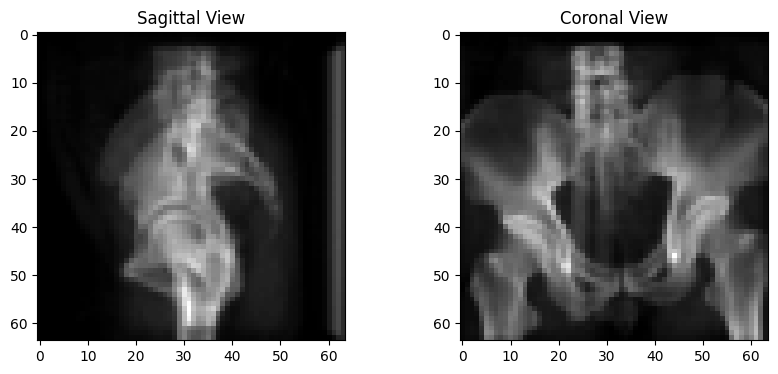

interactive(children=(IntSlider(value=32, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function __main__.show_slice(z)>

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import torch

# Load one batch
sag_img, cor_img, volume = next(iter(train_loader))

# Convert to CPU numpy
volume_np = volume[0, 0].cpu().numpy()  # shape: [D, H, W]

# Display sagittal & coronal views
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sag_img[0][0].cpu(), cmap='gray')
plt.title("Sagittal View")

plt.subplot(1, 2, 2)
plt.imshow(cor_img[0][0].cpu(), cmap='gray')
plt.title("Coronal View")
plt.show()

# Interactive slider for 3D volume slices
def show_slice(z):
    plt.figure(figsize=(5, 5))
    plt.imshow(volume_np[z], cmap='gray')
    plt.title(f"3D Volume - Axial Slice {z}")
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=volume_np.shape[0] - 1, step=1, value=volume_np.shape[0] // 2)
widgets.interact(show_slice, z=slider)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder for Sagittal (1x64x64, i.e., Width x Height x Depth)
class EncoderSagittal(nn.Module):
    def __init__(self, in_channels=1, out_channels=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),  # [B, 1, 1, 64, 64] -> [B, 16, 1, 32, 32]
            nn.ReLU(inplace=True),
            nn.Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1)),  # [B, 16, 1, 32, 32] -> [B, 32, 1, 16, 16]
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.unsqueeze(2)    # Adding the depth dimension to match [B, 32, 1, 64, 64]
        x = self.encoder(x)  # Output shape: [B, 32, 16, 16]
        return x  # Output shape: [B, 32, 1, 16, 16]


class EncoderCoronal(nn.Module):
    def __init__(self, in_channels=1, out_channels=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)),  # [B, 1, 64, 64, 1] -> [B, 16, 32, 32, 1]
            nn.ReLU(inplace=True),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)),  # [B, 16, 32, 32, 1] -> [B, 32, 16, 16, 1]
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.unsqueeze(4)    # Adding the depth dimension to match [B, 32, 64, 64, 1]
        x = self.encoder(x)  # Output shape: [B, 32, 16, 16]
        return x  # Output shape: [B, 32, 16, 16, 1]


class DepthExpander(nn.Module):
    def __init__(self, out_depth=16):
        super(DepthExpander, self).__init__()
        self.out_depth = out_depth
        # Anisotropic transposed convolution - only expands in depth dimension
        self.expand = nn.ConvTranspose3d(32, 32, kernel_size=(2, 1, 1), stride=(2, 1, 1))
        self.refine = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # print("Input to DepthExpander:", x.shape)
        while x.shape[2] < self.out_depth:
            x = self.expand(x)
            # print("  After expansion step:", x.shape)
        x = x[:, :, :self.out_depth, :, :]
        # print("  After cropping:", x.shape)
        x = self.refine(x)
        # print("  After refinement:", x.shape)
        return x


class WidthExpander(nn.Module):
    def __init__(self, out_width=16):
        super(WidthExpander, self).__init__()
        # Anisotropic transposed convolution - only expands in width dimension
        self.out_width = out_width
        self.expand = nn.ConvTranspose3d(32, 32, kernel_size=(1, 1, 2), stride=(1, 1, 2))
        self.refine = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # print("Input to WidthExpander:", x.shape)
        while x.shape[4] < self.out_width:
            x = self.expand(x)
            # print("  After expansion step:", x.shape)
        x = x[:, :, :, :, :self.out_width]
        # print("  After cropping:", x.shape)
        x = self.refine(x)
        # print("  After refinement:", x.shape)
        return x


class Volume3DDecoder(nn.Module):
    def __init__(self, out_channels=64):
        super(Volume3DDecoder, self).__init__()
        # Modified decoder using anisotropic convolutions for controlled expansion
        self.decoder = nn.Sequential(
            # First upsampling stage: 16→32 in each spatial dimension
            nn.ConvTranspose3d(64, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.BatchNorm3d(64),

            # Second upsampling stage: 32→64 in each spatial dimension
            nn.ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.BatchNorm3d(32),

            # Final refinement while maintaining dimensions
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(32),

            # Final output layer
            nn.Conv3d(32, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # print("Input to 3D Decoder:", x.shape)
        x = self.decoder(x)
        # print("Output from 3D Decoder:", x.shape)
        return x


class TransVert(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, intermediate_depth=16):
        super(TransVert, self).__init__()
        self.sagittal_encoder = EncoderSagittal(in_channels=in_channels)
        self.coronal_encoder = EncoderCoronal(in_channels=in_channels)
        self.depth_expander = DepthExpander(out_depth=intermediate_depth)
        self.width_expander = WidthExpander(out_width=intermediate_depth)
        self.decoder = Volume3DDecoder(out_channels=out_channels)

    def forward(self, sagittal_input, coronal_input):
        sagittal_encoded = self.sagittal_encoder(sagittal_input)
        coronal_encoded = self.coronal_encoder(coronal_input)
        depth_expanded = self.depth_expander(sagittal_encoded)
        width_expanded = self.width_expander(coronal_encoded)
        fused = torch.cat([depth_expanded, width_expanded], dim=1)
        volume_3d = self.decoder(fused)
        return volume_3d

In [9]:
sagittal_input = torch.randn(1, 1, 64, 64)  # Shape [B=2, C=1, H=64, W=64] for sagittal
coronal_input = torch.randn(1, 1, 64, 64)   # Shape [B=2, C=1, H=64, W=64] for coronal

    # Instantiate the TransVert model
model = TransVert(in_channels=1, out_channels=1, intermediate_depth=16)

    # Pass input through the model
output = model(sagittal_input, coronal_input)
    # Print shapes to verify
print("\n===== ARCHITECTURE FLOW =====")
print(f"Sagittal Input Shape: {sagittal_input.shape}")
print(f"Coronal Input Shape: {coronal_input.shape}")
print(f"Final 3D Volume Output Shape: {output.shape}")



===== ARCHITECTURE FLOW =====
Sagittal Input Shape: torch.Size([1, 1, 64, 64])
Coronal Input Shape: torch.Size([1, 1, 64, 64])
Final 3D Volume Output Shape: torch.Size([1, 1, 64, 64, 64])


In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Apply sigmoid if not already applied
        preds = torch.sigmoid(preds)

        # Flatten predictions and targets
        preds_flat = preds.view(preds.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        intersection = (preds_flat * targets_flat).sum(1)
        dice_score = (2. * intersection + self.smooth) / (preds_flat.sum(1) + targets_flat.sum(1) + self.smooth)

        dice_loss = 1 - dice_score
        return dice_loss.mean()


In [11]:
!pip install wandb


In [12]:
import wandb
!wandb login 47db746f38dd6216f60f4b6ce9c5d98e507dd6a3

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jeevan-neupane003 (jeevan-neupane003-khalti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50: 100%|██████████| 79/79 [02:52<00:00,  2.18s/it]


[Epoch 1] Train Dice Loss: 0.8620 | Val Dice Loss: 0.8811


Epoch 2/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 2] Train Dice Loss: 0.7631 | Val Dice Loss: 0.7461


Epoch 3/50: 100%|██████████| 79/79 [00:30<00:00,  2.61it/s]


[Epoch 3] Train Dice Loss: 0.7299 | Val Dice Loss: 0.7297


Epoch 4/50: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


[Epoch 4] Train Dice Loss: 0.7213 | Val Dice Loss: 0.7235


Epoch 5/50: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


[Epoch 5] Train Dice Loss: 0.7037 | Val Dice Loss: 0.7078


Epoch 6/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 6] Train Dice Loss: 0.6847 | Val Dice Loss: 0.6814


Epoch 7/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 7] Train Dice Loss: 0.6618 | Val Dice Loss: 0.6360


Epoch 8/50: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


[Epoch 8] Train Dice Loss: 0.5984 | Val Dice Loss: 0.5423


Epoch 9/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 9] Train Dice Loss: 0.5336 | Val Dice Loss: 0.5258


Epoch 10/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 10] Train Dice Loss: 0.4939 | Val Dice Loss: 0.5181


Epoch 11/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 11] Train Dice Loss: 0.4918 | Val Dice Loss: 0.4965


Epoch 12/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 12] Train Dice Loss: 0.4655 | Val Dice Loss: 0.4930


Epoch 13/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 13] Train Dice Loss: 0.4562 | Val Dice Loss: 0.4983


Epoch 14/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 14] Train Dice Loss: 0.4508 | Val Dice Loss: 0.4817


Epoch 15/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 15] Train Dice Loss: 0.4439 | Val Dice Loss: 0.4738


Epoch 16/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 16] Train Dice Loss: 0.4397 | Val Dice Loss: 0.4817


Epoch 17/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 17] Train Dice Loss: 0.4348 | Val Dice Loss: 0.4673


Epoch 18/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 18] Train Dice Loss: 0.4315 | Val Dice Loss: 0.4610


Epoch 19/50: 100%|██████████| 79/79 [00:29<00:00,  2.63it/s]


[Epoch 19] Train Dice Loss: 0.4259 | Val Dice Loss: 0.4709


Epoch 20/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 20] Train Dice Loss: 0.4213 | Val Dice Loss: 0.4559


Epoch 21/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 21] Train Dice Loss: 0.4192 | Val Dice Loss: 0.4514


Epoch 22/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 22] Train Dice Loss: 0.4137 | Val Dice Loss: 0.4485


Epoch 23/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 23] Train Dice Loss: 0.4149 | Val Dice Loss: 0.4454


Epoch 24/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 24] Train Dice Loss: 0.4119 | Val Dice Loss: 0.4382


Epoch 25/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 25] Train Dice Loss: 0.4073 | Val Dice Loss: 0.4431


Epoch 26/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 26] Train Dice Loss: 0.4058 | Val Dice Loss: 0.4352


Epoch 27/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 27] Train Dice Loss: 0.4037 | Val Dice Loss: 0.4349


Epoch 28/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 28] Train Dice Loss: 0.4025 | Val Dice Loss: 0.4449


Epoch 29/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 29] Train Dice Loss: 0.3985 | Val Dice Loss: 0.4389


Epoch 30/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 30] Train Dice Loss: 0.3977 | Val Dice Loss: 0.4377


Epoch 31/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 31] Train Dice Loss: 0.3948 | Val Dice Loss: 0.4375


Epoch 32/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 32] Train Dice Loss: 0.3924 | Val Dice Loss: 0.4312


Epoch 33/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 33] Train Dice Loss: 0.3937 | Val Dice Loss: 0.4273


Epoch 34/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 34] Train Dice Loss: 0.3885 | Val Dice Loss: 0.4297


Epoch 35/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 35] Train Dice Loss: 0.3898 | Val Dice Loss: 0.4298


Epoch 36/50: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


[Epoch 36] Train Dice Loss: 0.3858 | Val Dice Loss: 0.4377


Epoch 37/50: 100%|██████████| 79/79 [00:29<00:00,  2.64it/s]


[Epoch 37] Train Dice Loss: 0.3842 | Val Dice Loss: 0.4316


Epoch 38/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 38] Train Dice Loss: 0.3795 | Val Dice Loss: 0.4349


Epoch 39/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 39] Train Dice Loss: 0.3807 | Val Dice Loss: 0.4312


Epoch 40/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 40] Train Dice Loss: 0.3787 | Val Dice Loss: 0.4268


Epoch 41/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 41] Train Dice Loss: 0.3760 | Val Dice Loss: 0.4303


Epoch 42/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 42] Train Dice Loss: 0.3745 | Val Dice Loss: 0.4238


Epoch 43/50: 100%|██████████| 79/79 [00:29<00:00,  2.65it/s]


[Epoch 43] Train Dice Loss: 0.3709 | Val Dice Loss: 0.4215


Epoch 44/50: 100%|██████████| 79/79 [00:30<00:00,  2.63it/s]


[Epoch 44] Train Dice Loss: 0.3689 | Val Dice Loss: 0.4314


Epoch 45/50: 100%|██████████| 79/79 [00:29<00:00,  2.66it/s]


[Epoch 45] Train Dice Loss: 0.3666 | Val Dice Loss: 0.4296


Epoch 46/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 46] Train Dice Loss: 0.3645 | Val Dice Loss: 0.4231


Epoch 47/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 47] Train Dice Loss: 0.3626 | Val Dice Loss: 0.4188


Epoch 48/50: 100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


[Epoch 48] Train Dice Loss: 0.3621 | Val Dice Loss: 0.4214


Epoch 49/50: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


[Epoch 49] Train Dice Loss: 0.3577 | Val Dice Loss: 0.4235


Epoch 50/50: 100%|██████████| 79/79 [00:29<00:00,  2.68it/s]


[Epoch 50] Train Dice Loss: 0.3540 | Val Dice Loss: 0.4211


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▆▆▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training_batchwise_loss,██▇▇▆▆▄▄▄▄▃▃▂▃▂▃▂▄▂▂▃▃▂▂▂▂▃▂▃▂▃▅▂▂▂▂▂▁▂▂
val_batch_wise_loss,██▆▆▆▄▃▄▃▄▁▃▁▄▂▂▃▁▂▃▂▁▄▃▄▄▁▃▄▃▁▂▁▂▃▃▁▂▃▃
val_loss,█▆▆▅▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.35403
training_batchwise_loss,0.41556
val_batch_wise_loss,0.32157
val_loss,0.42112


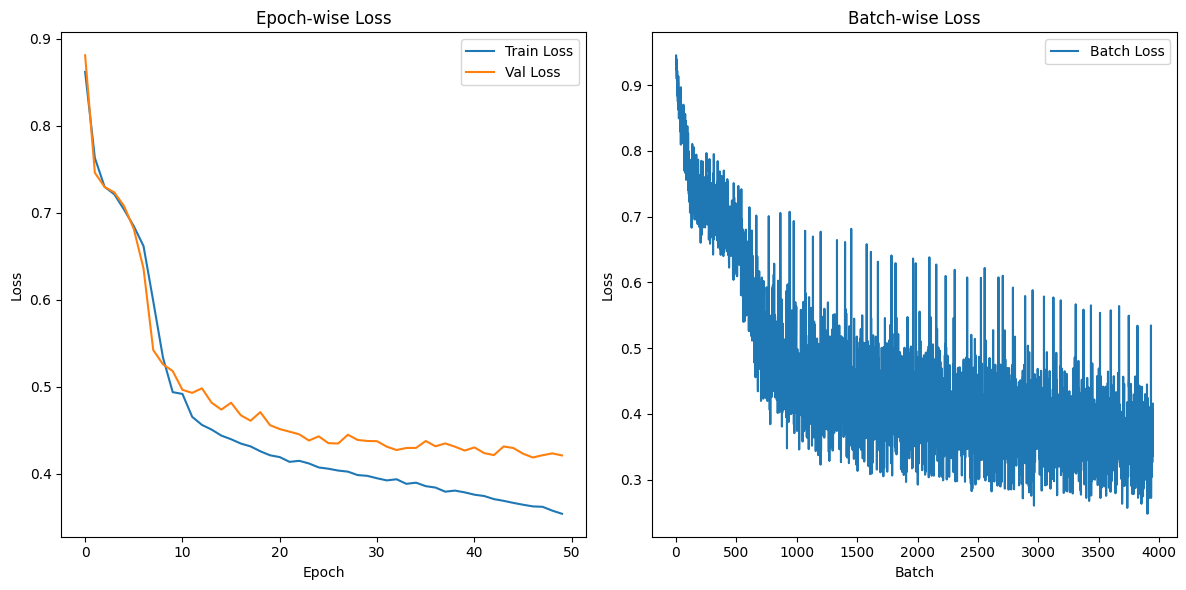

In [13]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
lr = 1e-4
use_wandb = True  # Toggle wandb logging

# --- Model, Loss, Optimizer ---
model = TransVert(in_channels=1, out_channels=1, intermediate_depth=16).to(device)
criterion = DiceLoss()  # <-- Using your custom DiceLoss
optimizer = optim.Adam(model.parameters(), lr=lr)

# --- Optional: Initialize wandb ---
if use_wandb:
    wandb.init(project="TransvertFinal", config={"epochs": num_epochs, "lr": lr})

# --- Track losses ---
batch_losses, train_epoch_losses, val_epoch_losses = [], [], []

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss, batch_loss_epoch = 0.0, []

    for batch_idx, (sagittal, coronal, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        sagittal, coronal, target = sagittal.to(device), coronal.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(sagittal, coronal)  # Output shape: [B, 1, 64, 64, 64]

        loss = criterion(output, target)   # Compute Dice loss
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value
        batch_loss_epoch.append(loss_value)

        # Log batch loss to wandb
        if use_wandb:
            wandb.log({
                "training_batchwise_loss": loss_value
            })

    avg_train_loss = running_loss / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    batch_losses.append(batch_loss_epoch)

    # --- Validation Loop ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_batch_idx, (sagittal, coronal, target) in enumerate(val_loader):
            sagittal, coronal, target = sagittal.to(device), coronal.to(device), target.to(device)
            output = model(sagittal, coronal)
            loss = criterion(output, target)  # Use Dice loss
            val_loss += loss.item()

            # Log batch validation loss
            if use_wandb:
                wandb.log({
                    "val_batch_wise_loss": loss.item()
                })

    avg_val_loss = val_loss / len(val_loader)
    val_epoch_losses.append(avg_val_loss)

    # --- Logging Epoch Losses ---
    if use_wandb:
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        })

    print(f"[Epoch {epoch+1}] Train Dice Loss: {avg_train_loss:.4f} | Val Dice Loss: {avg_val_loss:.4f}")

# --- Finish wandb ---
if use_wandb:
    wandb.finish()

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Epoch-wise Loss
plt.subplot(1, 2, 1)
plt.plot(train_epoch_losses, label='Train Loss')
plt.plot(val_epoch_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch-wise Loss")
plt.legend()

# Batch-wise Loss
plt.subplot(1, 2, 2)
flattened = [loss for epoch_losses in batch_losses for loss in epoch_losses]
plt.plot(flattened, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Batch-wise Loss")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20: 100%|██████████| 79/79 [02:01<00:00,  1.54s/it]


[Epoch 1] Train Dice Loss: 0.8663 | Val Dice Loss: 0.8044


Epoch 2/20: 100%|██████████| 79/79 [02:00<00:00,  1.53s/it]


[Epoch 2] Train Dice Loss: 0.7631 | Val Dice Loss: 0.7581


Epoch 3/20: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it]


[Epoch 3] Train Dice Loss: 0.7301 | Val Dice Loss: 0.7252


Epoch 4/20: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]


[Epoch 4] Train Dice Loss: 0.7112 | Val Dice Loss: 0.7238


Epoch 5/20: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it]


[Epoch 5] Train Dice Loss: 0.6922 | Val Dice Loss: 0.7248


Epoch 6/20: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it]


[Epoch 6] Train Dice Loss: 0.6582 | Val Dice Loss: 0.6089


Epoch 7/20: 100%|██████████| 79/79 [01:59<00:00,  1.52s/it]


[Epoch 7] Train Dice Loss: 0.5883 | Val Dice Loss: 0.5494


Epoch 8/20: 100%|██████████| 79/79 [02:02<00:00,  1.55s/it]


[Epoch 8] Train Dice Loss: 0.5314 | Val Dice Loss: 0.5270


Epoch 9/20: 100%|██████████| 79/79 [02:00<00:00,  1.52s/it]


[Epoch 9] Train Dice Loss: 0.4909 | Val Dice Loss: 0.5044


Epoch 10/20: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]


[Epoch 10] Train Dice Loss: 0.4690 | Val Dice Loss: 0.5599


Epoch 11/20: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]


[Epoch 11] Train Dice Loss: 0.4600 | Val Dice Loss: 0.4810


Epoch 12/20: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it]


[Epoch 12] Train Dice Loss: 0.4473 | Val Dice Loss: 0.4709


Epoch 13/20: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]


[Epoch 13] Train Dice Loss: 0.4398 | Val Dice Loss: 0.4783


Epoch 14/20: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]


[Epoch 14] Train Dice Loss: 0.4343 | Val Dice Loss: 0.4737


Epoch 15/20: 100%|██████████| 79/79 [01:59<00:00,  1.51s/it]


[Epoch 15] Train Dice Loss: 0.4310 | Val Dice Loss: 0.4627


Epoch 16/20: 100%|██████████| 79/79 [02:00<00:00,  1.53s/it]


[Epoch 16] Train Dice Loss: 0.4243 | Val Dice Loss: 0.4576


Epoch 17/20: 100%|██████████| 79/79 [01:59<00:00,  1.52s/it]


[Epoch 17] Train Dice Loss: 0.4233 | Val Dice Loss: 0.4618


Epoch 18/20: 100%|██████████| 79/79 [02:05<00:00,  1.59s/it]


[Epoch 18] Train Dice Loss: 0.4181 | Val Dice Loss: 0.4516


Epoch 19/20: 100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


[Epoch 19] Train Dice Loss: 0.4155 | Val Dice Loss: 0.4499


Epoch 20/20: 100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


[Epoch 20] Train Dice Loss: 0.4136 | Val Dice Loss: 0.4472


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
eval/avg_dice_score,▁▁▁▃▄▄▄▄▄▅▆▆▆▆▆▇▇▇▆▇▇▇▇█▇█▇█████████████
eval/avg_loss,█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/batch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
eval/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇████
eval_sample_0/dice_loss,██▅▅▅▅▅▅▅▅▅▅▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁
eval_sample_0/dice_score,▂▂▁▁▁▃▄▄▄▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████▇██████
eval_sample_1/dice_loss,█▅▆▆▅▆▆▅▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▂▂▁
eval_sample_1/dice_score,▂▂▁▂▂▃▂▃▁▃▃▃▄▄▄▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██▇
eval_sample_2/dice_loss,█▆▆▅▅▅▅▄▄▅▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
eval_sample_2/dice_score,▂▁▁▁▄▄▄▄▄▄▅▅▄▅▅▅▆▆▆▇▇▇▇▇▇▇██▇████▇██████


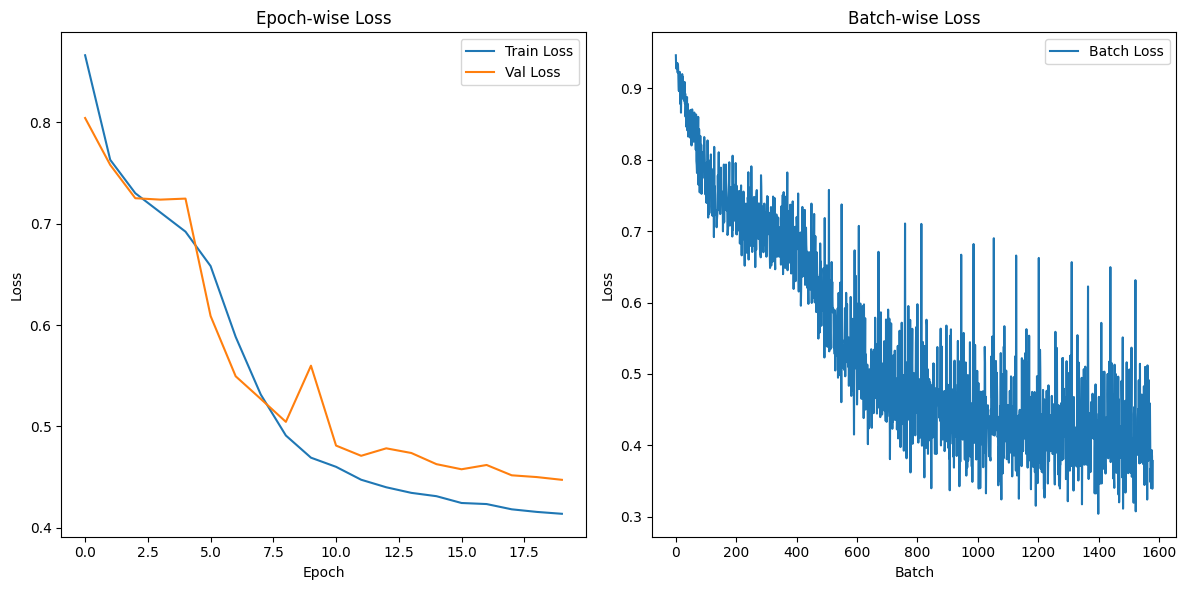

In [17]:
import torch
import torch.optim as optim
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
lr = 1e-4
use_wandb = True

model = TransVert(in_channels=1, out_channels=1, intermediate_depth=16).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

if use_wandb:
    wandb.init(project="TransvertFinal", config={"epochs": num_epochs, "lr": lr})

# --- Track Losses ---
batch_losses, train_epoch_losses, val_epoch_losses = [], [], []

# --- Dice Score Function ---
def dice_score_binary(pred, target, threshold=0.5, eps=1e-6):
    pred = (pred > threshold).float()
    target = (target > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3, 4))
    union = pred.sum(dim=(1, 2, 3, 4)) + target.sum(dim=(1, 2, 3, 4))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean()

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss, batch_loss_epoch = 0.0, []

    for batch_idx, (sagittal, coronal, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        sagittal, coronal, target = sagittal.to(device), coronal.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(sagittal, coronal)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value
        batch_loss_epoch.append(loss_value)

        if use_wandb:
            wandb.log({"training_batchwise_loss": loss_value})

        # --- Inline Evaluation on Eval Set ---
        model.eval()
        eval_dice_scores, eval_losses = [], []

        with torch.no_grad():
            for eval_idx, (s_eval, c_eval, t_eval) in enumerate(eval_loader):
                s_eval, c_eval, t_eval = s_eval.to(device), c_eval.to(device), t_eval.to(device).float()
                output_eval = model(s_eval, c_eval)

                eval_loss = criterion(output_eval, t_eval)
                eval_losses.append(eval_loss.item())

                pred_eval = (output_eval > 0).float()
                dice_eval = dice_score_binary(pred_eval, t_eval)
                eval_dice_scores.append(dice_eval.item())

                if eval_idx < 5:
                    pred_np = pred_eval[0, 0].cpu().numpy()
                    target_np = t_eval[0, 0].cpu().numpy()
                    diff_np = (pred_np != target_np).astype(float)

                    wandb.log({
                        f"eval_sample_{eval_idx}/dice_score": dice_eval.item(),
                        f"eval_sample_{eval_idx}/dice_loss": eval_loss.item(),
                        f"eval_sample_{eval_idx}/pred_mid_slice": wandb.Image(pred_np[32]),
                        f"eval_sample_{eval_idx}/target_mid_slice": wandb.Image(target_np[32]),
                        f"eval_sample_{eval_idx}/diff_mid_slice": wandb.Image(diff_np[32]),
                        "eval/epoch": epoch + 1,
                        "eval/batch": batch_idx + 1 + epoch * len(train_loader),
                    })

        avg_eval_loss = sum(eval_losses) / len(eval_losses)
        avg_eval_dice = sum(eval_dice_scores) / len(eval_dice_scores)

        if use_wandb:
            wandb.log({
                "eval/avg_loss": avg_eval_loss,
                "eval/avg_dice_score": avg_eval_dice,
                "eval/epoch": epoch + 1,
                "eval/batch": batch_idx + 1 + epoch * len(train_loader),
            })

        model.train()

    avg_train_loss = running_loss / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    batch_losses.append(batch_loss_epoch)

    # --- Validation Pass ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sagittal, coronal, target in val_loader:
            sagittal, coronal, target = sagittal.to(device), coronal.to(device), target.to(device)
            output = model(sagittal, coronal)
            loss = criterion(output, target)
            val_loss += loss.item()
            if use_wandb:
                wandb.log({"val_batch_wise_loss": loss.item()})

    avg_val_loss = val_loss / len(val_loader)
    val_epoch_losses.append(avg_val_loss)

    if use_wandb:
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        })

    print(f"[Epoch {epoch+1}] Train Dice Loss: {avg_train_loss:.4f} | Val Dice Loss: {avg_val_loss:.4f}")

# --- Wrap Up ---
if use_wandb:
    wandb.finish()

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Epoch-wise Loss
plt.subplot(1, 2, 1)
plt.plot(train_epoch_losses, label='Train Loss')
plt.plot(val_epoch_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch-wise Loss")
plt.legend()

# Batch-wise Loss
plt.subplot(1, 2, 2)
flattened = [loss for epoch_losses in batch_losses for loss in epoch_losses]
plt.plot(flattened, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Batch-wise Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import torch
from tqdm import tqdm
import wandb

# Initialize wandb logging
wandb.init(project="TransvertFinal")

# Dice Score (Binary)
def dice_score_binary(pred, target, threshold=0.5, eps=1e-6):
    # Ensure both pred and target are binary (0 or 1)
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    # Compute intersection and union
    intersection = (pred * target).sum(dim=(1, 2, 3, 4))
    union = pred.sum(dim=(1, 2, 3, 4)) + target.sum(dim=(1, 2, 3, 4))

    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean()  # average over batch

# Model evaluation function
def evaluate_model(model, test_loader, device="cuda"):
    model.eval()
    dice_scores = []
    dice_losses = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(test_loader, desc="Evaluating on Test Set")):
            sagittal, coronal, target = batch
            sagittal = sagittal.to(device)
            coronal = coronal.to(device)
            target = target.to(device).float()

            # Model output (logits)
            output = model(sagittal, coronal)

            # 1. Compute Dice Loss (from the DiceLoss class)
            criterion = DiceLoss()  # Using Dice Loss class
            loss = criterion(output, target)
            dice_losses.append(loss.item())

            # 2. Binarize the output and compute Dice Score
            pred = (output > 0).float()  # Binarize the predictions
            dice_score = dice_score_binary(pred, target)
            dice_scores.append(dice_score.item())

            # Log visuals and Dice score for the first 3 batches
            if idx < 3:
                pred_np = pred[0, 0].cpu().numpy()
                target_np = target[0, 0].cpu().numpy()
                diff_np = (pred_np != target_np).astype(float)

                wandb.log({
                    f"sample_{idx}/dice_score": dice_score.item(),
                    f"sample_{idx}/dice_loss": loss.item(),
                    f"sample_{idx}/pred_mid_slice": wandb.Image(pred_np[32]),
                    f"sample_{idx}/target_mid_slice": wandb.Image(target_np[32]),
                    f"sample_{idx}/diff_mid_slice": wandb.Image(diff_np[32]),
                })

    # Average Dice Score and Dice Loss over the test set
    avg_dice_score = sum(dice_scores) / len(dice_scores)
    avg_dice_loss = sum(dice_losses) / len(dice_losses)

    # Log final average Dice Score and Dice Loss to wandb
    wandb.log({"test/avg_dice_score": avg_dice_score, "test/avg_dice_loss": avg_dice_loss})

    print(f"\n✅ Average Dice Score on Test Set: {avg_dice_score:.4f}")
    print(f"✅ Average Dice Loss on Test Set: {avg_dice_loss:.4f}")

    # Finish wandb logging
    wandb.finish()

    return avg_dice_score, avg_dice_loss


In [15]:
avg_dice_score, avg_dice_loss = evaluate_model(model, test_loader, device="cuda")


Evaluating on Test Set: 100%|██████████| 11/11 [00:22<00:00,  2.02s/it]


✅ Average Dice Score on Test Set: 0.5681
✅ Average Dice Loss on Test Set: 0.4330


sample_0/dice_loss,▁
sample_0/dice_score,▁
sample_1/dice_loss,▁
sample_1/dice_score,▁
sample_2/dice_loss,▁
sample_2/dice_score,▁
test/avg_dice_loss,▁
test/avg_dice_score,▁
sample_0/dice_loss,0.36995
sample_0/dice_score,0.63073
sample_1/dice_loss,0.42577


In [16]:
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np

# Ensure model is in eval mode
model.eval()

# Store predictions and ground truths
predictions = []
ground_truths = []

# Inference on all 4 eval samples
with torch.no_grad():
    for sagittal, coronal, target in eval_loader:
        sagittal, coronal = sagittal.to(device), coronal.to(device)
        output = model(sagittal, coronal)
        output = torch.sigmoid(output)  # Ensure output is between 0-1

        pred_np = output[0, 0].cpu().numpy()
        target_np = target[0, 0].cpu().numpy()

        # Normalize for visualization
        pred_np = (pred_np - pred_np.min()) / (pred_np.max() - pred_np.min())
        target_np = (target_np - target_np.min()) / (target_np.max() - target_np.min())

        predictions.append(pred_np)
        ground_truths.append(target_np)

# Interactive viewer
def view_eval_sample(sample_index, slice_index):
    pred_vol = predictions[sample_index]
    gt_vol = ground_truths[sample_index]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(gt_vol[slice_index], cmap='gray')
    plt.title(f"Ground Truth - Sample {sample_index}, Slice {slice_index}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_vol[slice_index], cmap='gray')
    plt.title(f"Prediction - Sample {sample_index}, Slice {slice_index}")
    plt.axis('off')

    plt.show()

# Widgets
sample_slider = widgets.IntSlider(min=0, max=3, step=1, description='Sample')
slice_slider = widgets.IntSlider(min=0, max=63, step=1, description='Slice')

widgets.interact(view_eval_sample, sample_index=sample_slider, slice_index=slice_slider)


interactive(children=(IntSlider(value=0, description='Sample', max=3), IntSlider(value=0, description='Slice',…

<function __main__.view_eval_sample(sample_index, slice_index)>